In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import cv2

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score
from tqdm import tqdm
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Brain Tumor Images
folder_path = 'Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

# Normal Brain Images
folder_path = 'Brain Tumor Data Set/Healthy'
image_files_normal = [file for file in os.listdir(folder_path)]

url_tumor = 'Brain Tumor Data Set/Brain Tumor/'
url_healthy = 'Brain Tumor Data Set/Healthy/'

### Visualizing the data

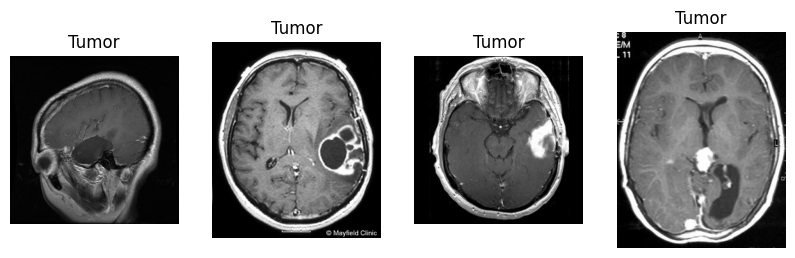

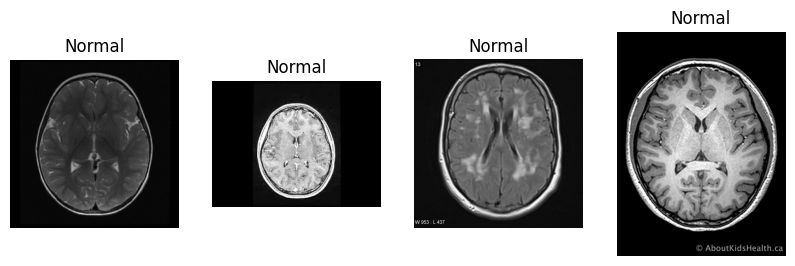

In [9]:
# Displaying Brain Tumor Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Brain Tumor/' + image_files_tumor[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Tumor')
plt.show()

# Displaying Normal Brain Images
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(mpimg.imread('Brain Tumor Data Set/Healthy/' + image_files_normal[i+5]))
    ax[i].axis('off')
    ax[i].set_title('Normal')
    
plt.show()

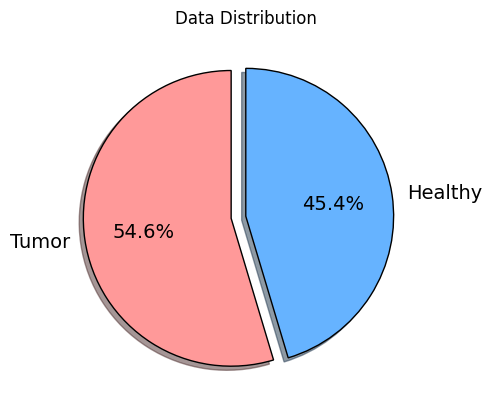

In [10]:
# visualizing the data distribution
data = {'Tumor': len(image_files_tumor), 'Healthy': len(image_files_normal)}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots()
ax.pie(values, labels=names, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'], explode=(0.1, 0), shadow=True, textprops={'fontsize': 14}, wedgeprops={'edgecolor': 'black'})
ax.set_title('Data Distribution')
plt.show()

In [3]:
# Merging the data
data = []
data_gray = []
for file in image_files_tumor:
    # save the image and the label (1 for tumor)
    img = cv2.imread(url_tumor + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 1]) # 1 for tumor
    data_gray.append([grayscale_image, 1])
  
for file in image_files_normal:
    img = cv2.imread(url_healthy + file)
    resized_image = cv2.resize(img, (175,175), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    data.append([resized_image, 0]) # 0 for normal
    data_gray.append([grayscale_image, 0])
    
# Creating a DataFrame
df = pd.DataFrame(data, columns=['image', 'label'])

# Shuffling the data
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df_gray =  pd.DataFrame(data_gray, columns=['image', 'label'])
df_gray = df_gray.sample(frac=1).reset_index(drop=True)

In [10]:
# We have a meta data file that contains more information about the images

# Load the meta data
meta_data = pd.read_csv('metadata.csv', index_col=0)
meta_data.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


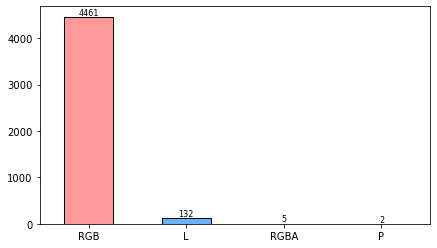

In [11]:
meta_data['mode'].value_counts().plot(kind='bar', color=['#ff9999','#66b3ff', '#ff55','#66b344'], rot=0, figsize=(7, 4), edgecolor='black')
for i, v in enumerate(meta_data['mode'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()

#### Step 1: Train and Test the model with RGB images and flatting the data

In [4]:
# Split the data
X = np.array(df['image'].values.tolist())
y = df['label'].values

# Normalizing the data
X = X/ 255

In [5]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:
# Flatten the image data
X_train_flat = np.array([x.flatten() for x in X_train])
X_val_flat = np.array([x.flatten() for x in X_val])

#### KNN Model

In [21]:
# Create KNN model
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X_train_flat, y_train)

# Predict the validation data
y_pred = knn.predict(X_val_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9429347826086957


#### XGBoost Model

In [ ]:
# Create the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model.fit(X_train_flat, y_train)

# Make predictions
y_pred = model.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Initial Accuracy: {accuracy:.4f}')

#### Random Forest Model


In [64]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_flat, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Random Forest Validation Accuracy: 0.9633


In [22]:
# Perform hyperparameter tuning with RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(10, 31, 10)),
    'min_samples_split': randint(2, 11)
}

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=4, refit='accuracy', scoring=scoring, cv=2, random_state=42, n_jobs=-1,verbose=True)
random_search_rf.fit(X_train_flat, y_train)

# Print the best parameters and the best score
print(f"Random Forest Best parameters: {random_search_rf.best_params_}")
print(f"Random Forest Best accuracy: {random_search_rf.best_score_:.4f}")

# Use the best model to make predictions
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_val_flat)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')
f1_rf = f1_score(y_val, y_pred_rf, average='weighted')
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')
print(f'Random Forest Validation Precision: {precision_rf:.4f}')
print(f'Random Forest Validation Recall: {recall_rf:.4f}')
print(f'Random Forest Validation F1 Score: {f1_rf:.4f}')


Fitting 2 folds for each of 4 candidates, totalling 8 fits
Random Forest Best parameters: {'max_depth': None, 'min_samples_split': 8, 'n_estimators': 221}
Random Forest Best accuracy: 0.9161
Random Forest Validation Accuracy: 0.9633
Random Forest Validation Precision: 0.9638
Random Forest Validation Recall: 0.9633
Random Forest Validation F1 Score: 0.9632


In [23]:
# save the rf model
joblib.dump(best_rf_model, 'random_search_rf.pkl')

['random_search_rf.pkl']

In [17]:
# load the rf model
loaded_rf_model = joblib.load('random_search_rf.pkl')

#### Principal Component Analysis (PCA)

In [25]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=8, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_pca, y_train)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f'Random Forest Validation Accuracy with PCA: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.38step/s]

Random Forest Validation Accuracy with PCA: 0.9620


##### Vizualizing the images after PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


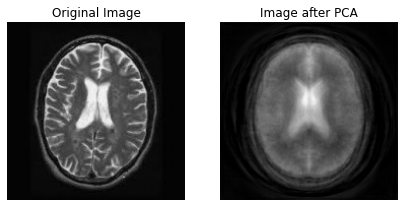

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(X_train_flat[8].reshape(175, 175, 3))
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(pca.inverse_transform(X_train_pca[8]).reshape(175, 175, 3))
ax[1].axis('off')
ax[1].set_title('Image after PCA')

plt.show()

#### Voting Classifier 

In [22]:


# Create the models
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
rf = RandomForestClassifier(n_estimators=221, max_depth=None, min_samples_split=8, random_state=42)
svc = SVC(C=1, kernel='linear', probability=True)
lr = LogisticRegression(C=1, max_iter=1000)

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('svc', svc), ('lr', lr)], voting='soft')

# Train the model
voting_clf.fit(X_train_flat, y_train)

# Make predictions
y_pred = voting_clf.predict(X_val_flat)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Voting Classifier Validation Accuracy: {accuracy:.4f}')

Voting Classifier Validation Accuracy: 0.9524


In [24]:
# save the model
joblib.dump(voting_clf, 'voting_clf.pkl')

['voting_clf.pkl']

#### Step 2: Train and test models with grayscale images and flatten

In [10]:
X_gray = np.array(df_gray['image'].values.tolist())
y_gray = df_gray['label'].values

# Normalizing the data
X_gray = X_gray/ 255

# Splitting the data into training and testing sets
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size=0.2, random_state=42, stratify=y_gray)

# Splitting the data into training and validation sets
X_train_gray, X_val_gray, y_train_gray, y_val_gray = train_test_split(X_train_gray, y_train_gray, test_size=0.2, random_state=42, stratify=y_train_gray)

# Flatten the image data
X_train_flat_gray = np.array([x.flatten() for x in X_train_gray])
X_val_flat_gray = np.array([x.flatten() for x in X_val_gray])

In [25]:
# Create the XGBoost model
model_gray = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Train the model without hyperparameter tuning
model_gray.fit(X_train_flat_gray, y_train_gray)

# Make predictions
y_pred_gray = model_gray.predict(X_val_flat_gray)

# Evaluate the model
accuracy_gray = accuracy_score(y_val_gray, y_pred_gray)

print(f'Initial Accuracy with grayscale images: {accuracy_gray:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Initial Accuracy with grayscale images: 0.9579


In [26]:
# save xgboost model
joblib.dump(model_gray, 'xgboost_gray_model.pkl')

['xgboost_gray_model.pkl']

In [32]:
# Create the Random Forest model with predefined parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_flat_gray, y_train_gray)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_flat_gray)

# Evaluate the model
accuracy_rf = accuracy_score(y_val_gray, y_pred_rf)
print(f'Random Forest Validation Accuracy: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01step/s]

Random Forest Validation Accuracy: 0.9470


In [33]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flat_gray)
X_val_pca = pca.transform(X_val_flat_gray)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=8, random_state=42)

with tqdm(total=100, desc='Training Progress', unit='step') as pbar:
    # Update progress for each stage of training
    rf_model.fit(X_train_pca, y_train_gray)
    pbar.update(100)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_val_pca)

# Evaluate the model
accuracy_rf = accuracy_score(y_val_gray, y_pred_rf)
print(f'Random Forest Validation Accuracy with PCA: {accuracy_rf:.4f}')

Training Progress: 100%|███████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28step/s]

Random Forest Validation Accuracy with PCA: 0.9592


In [13]:
def resize_images(images):
    # Initialize an array with the shape (num_samples, 224, 224, 1) for grayscale images
    resized_images = np.zeros((images.shape[0], 224, 224, 1))
    for i in range(images.shape[0]):
        # Ensure the image has shape (height, width, 1)
        if images[i].ndim == 2:  # If image is (height, width), add channel dimension
            image = np.expand_dims(images[i], axis=-1)
        elif images[i].ndim == 3 and images[i].shape[2] == 1:  # If image is already (height, width, 1)
            image = images[i]
        else:
            raise ValueError("Unexpected image shape: {}".format(images[i].shape))

        # Resize and expand dimensions to include the channel
        resized_image = tf.image.resize(image, (224, 224)).numpy()
        resized_images[i] = resized_image
    return resized_images

In [14]:
X_train_resized = resize_images(X_train_gray)
X_val_resized = resize_images(X_val_gray)
X_test_resized = resize_images(X_test_gray)

In [23]:
# Function to plot loss and accuracy
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plotting Loss
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    # Plotting Accuracy
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    plt.show()

# Assuming y_true and y_pred are defined
def plot_precision_recall(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

In [65]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [16]:
datagen = ImageDataGenerator(
    validation_split=0.2,  # Reserve 20% of images for validation
    horizontal_flip=True,
)

# Create generators for training and validation sets
train_generator = datagen.flow(
    X_train_resized, y_train,
    batch_size=256,
    subset='training'
)

val_generator = datagen.flow(
    X_val_resized, y_val,
    batch_size=256,
    subset='validation'
)

In [17]:
# Initialize a Sequential model
model = Sequential()

# Add Convolutional layers and pooling
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)))  # For grayscale
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output to feed into Dense layers
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary_crossentropy loss and specified metrics
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,073 (789.35 KB)

 Trainable params: 202,057 (789.29 KB)

 Non-trainable params: 16 (64.00 B)

In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15


c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6082 - loss: 0.6749 - val_accuracy: 0.5986 - val_loss: 0.6614
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 958ms/step - accuracy: 0.7501 - loss: 0.5666 - val_accuracy: 0.7823 - val_loss: 0.6245
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - accuracy: 0.7989 - loss: 0.4990 - val_accuracy: 0.8367 - val_loss: 0.5810
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - accuracy: 0.8423 - loss: 0.4193 - val_accuracy: 0.9048 - val_loss: 0.5410
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - accuracy: 0.9050 - loss: 0.3353 - val_accuracy: 0.9320 - val_loss: 0.5383
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 555ms/step - accuracy: 0.9249 - loss: 0.2964 - val_accuracy: 0.8707 - val_loss: 0.5291
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 576ms/step - accuracy: 0.9391 - loss: 0.2785 - val_accuracy: 0.9184 - val_loss: 0.4941
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step - accuracy: 0.9567 - loss: 0.2405 - val_accuracy: 0.9320 - val_l

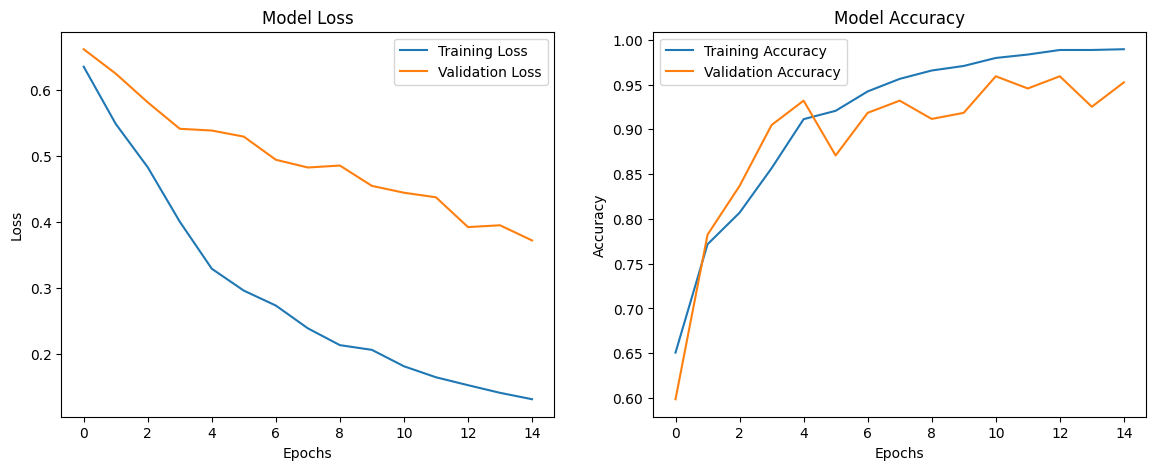

In [19]:
# save the model
model.save('brain_tumor_cnn_model.h5')

# Plot loss and accuracy
plot_loss_accuracy(history)

In [15]:
# Load the model
cnn_model = tf.keras.models.load_model('brain_tumor_cnn_model.h5')

In [20]:
loss,accuracy = model.evaluate(X_test_resized,y_test, verbose=1)
print(f"Loss: {loss} Accuracy: {accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9545 - loss: 0.3756
Loss: 0.373444139957428 Accuracy: 0.958695650100708


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Precision: 0.9625
Recall: 0.9555


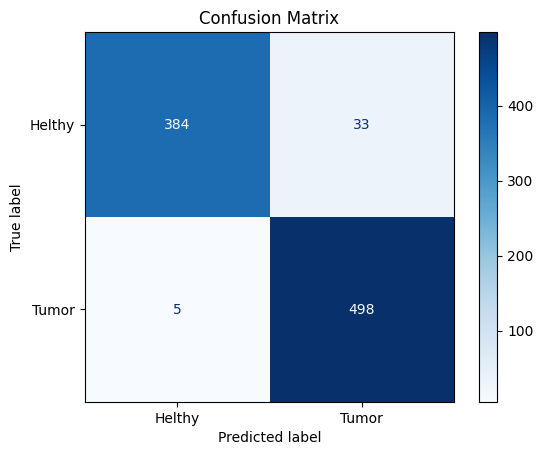

In [24]:
# Make predictions
y_pred = cnn_model.predict(X_test_resized)
y_pred = (y_pred > 0.5).astype(int)

# Plot metrics
plot_precision_recall(y_test, y_pred)

# Assuming you have class names in a list called `class_names`
class_names = ['Helthy', 'Tumor']
plot_confusion_matrix(y_test, y_pred, class_names)

Sample image shape: (1, 224, 224, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  1%|          | 10/1000 [00:00<00:15, 64.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 20/1000 [00:00<00:13, 72.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 30/1000 [00:00<00:11, 81.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 40/1000 [00:00<00:10, 88.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  5%|▌         | 50/1000 [00:00<00:10, 88.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 60/1000 [00:00<00:10, 90.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|▋         | 70/1000 [00:00<00:10, 87.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 80/1000 [00:00<00:10, 88.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 90/1000 [00:01<00:09, 91.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 10%|█         | 100/1000 [00:01<00:11, 78.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 112/1000 [00:01<00:10, 86.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 121/1000 [00:01<00:10, 86.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 78.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 145/1000 [00:01<00:08, 96.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 16%|█▌        | 156/1000 [00:01<00:08, 94.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 166/1000 [00:01<00:09, 89.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 176/1000 [00:02<00:09, 87.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 185/1000 [00:02<00:09, 88.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 194/1000 [00:02<00:09, 85.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 203/1000 [00:02<00:09, 82.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 212/1000 [00:02<00:09, 81.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 221/1000 [00:02<00:09, 80.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 81.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 240/1000 [00:02<00:09, 84.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 25%|██▌       | 250/1000 [00:02<00:08, 83.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 79.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 80.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 76.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▉       | 290/1000 [00:03<00:09, 77.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███       | 300/1000 [00:03<00:08, 79.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 31%|███       | 310/1000 [00:03<00:08, 77.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 320/1000 [00:03<00:08, 78.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 330/1000 [00:03<00:08, 78.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 76.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 80.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▌      | 360/1000 [00:04<00:07, 82.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 380/1000 [00:04<00:06, 93.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 390/1000 [00:04<00:06, 91.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 400/1000 [00:04<00:06, 87.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 410/1000 [00:04<00:06, 89.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▎     | 425/1000 [00:04<00:05, 105.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▎     | 436/1000 [00:05<00:05, 105.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 447/1000 [00:05<00:05, 102.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|████▌     | 458/1000 [00:05<00:05, 98.40it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 86.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 480/1000 [00:05<00:05, 89.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 490/1000 [00:05<00:05, 86.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 50%|█████     | 500/1000 [00:05<00:06, 81.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 51%|█████     | 510/1000 [00:05<00:05, 81.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 520/1000 [00:06<00:05, 82.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 85.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 89.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▌    | 550/1000 [00:06<00:04, 91.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 56%|█████▌    | 560/1000 [00:06<00:04, 93.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▊    | 575/1000 [00:06<00:04, 105.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▊    | 586/1000 [00:06<00:03, 106.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 600/1000 [00:06<00:04, 90.26it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 61%|██████    | 610/1000 [00:07<00:04, 84.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 84.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 86.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▍   | 645/1000 [00:07<00:03, 98.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 656/1000 [00:07<00:03, 101.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 667/1000 [00:07<00:03, 98.33it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 677/1000 [00:07<00:03, 92.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 69%|██████▊   | 687/1000 [00:07<00:03, 92.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 70%|██████▉   | 697/1000 [00:08<00:04, 74.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 71%|███████   | 706/1000 [00:08<00:05, 58.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 71%|███████▏  | 713/1000 [00:08<00:05, 50.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 720/1000 [00:08<00:05, 46.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 730/1000 [00:08<00:05, 50.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 74%|███████▍  | 740/1000 [00:09<00:05, 51.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 75%|███████▌  | 750/1000 [00:09<00:04, 51.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 76%|███████▌  | 760/1000 [00:09<00:04, 53.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 770/1000 [00:09<00:04, 53.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 780/1000 [00:09<00:03, 55.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|███████▉  | 790/1000 [00:09<00:03, 53.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 80%|████████  | 800/1000 [00:10<00:03, 52.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 81%|████████  | 810/1000 [00:10<00:03, 50.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 82%|████████▏ | 820/1000 [00:10<00:03, 52.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████▎ | 830/1000 [00:10<00:03, 56.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 84%|████████▍ | 840/1000 [00:10<00:02, 57.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 85%|████████▌ | 850/1000 [00:11<00:02, 55.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 860/1000 [00:11<00:02, 58.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 87%|████████▋ | 870/1000 [00:11<00:02, 59.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 88%|████████▊ | 880/1000 [00:11<00:02, 53.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 89%|████████▉ | 890/1000 [00:11<00:02, 51.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 53.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 55.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 920/1000 [00:12<00:01, 55.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 93%|█████████▎| 930/1000 [00:12<00:01, 56.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 94%|█████████▍| 940/1000 [00:12<00:01, 52.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 51.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 52.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 55.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 54.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 50.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


100%|██████████| 1000/1000 [00:13<00:00, 72.16it/s]


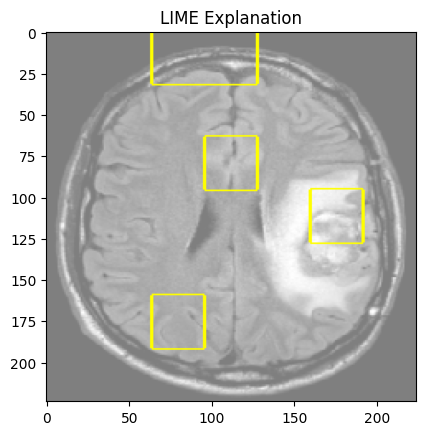

In [4]:

model = tf.keras.models.load_model('brain_tumor_cnn_model.h5')
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (1).png'

# Function to preprocess image for the model
def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Load your model (replace 'your_model.h5' with your actual model file)

# Ensure the model is compiled
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Function to predict the class
def predict_fn(images):
    images = np.array(images)
    if images.ndim == 3:
        images = np.expand_dims(images, axis=0)
    preds = model.predict(images)
    return preds

# Custom segmentation function for grayscale images
def segmentation_fn(image):
    return slic(image, n_segments=50, compactness=10, sigma=1, start_label=1)


sample_image = preprocess_image(sample_image_path)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(
    sample_image[0].astype('double'), 
    predict_fn, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000,
    segmentation_fn=segmentation_fn
)

# Convert the grayscale image to RGB for visualization
def convert_to_rgb(image):
    if image.ndim == 2 or image.shape[-1] == 1:
        image = np.dstack([image, image, image])
    return image

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=False
)

# Convert the grayscale image to RGB for mark_boundaries
temp_rgb = convert_to_rgb(temp / 2 + 0.5)
plt.imshow(mark_boundaries(temp_rgb, mask))
plt.title('LIME Explanation')
plt.show()

#### Canny edge detection

In [11]:
def apply_canny_edge_detection(image, low_threshold=50, high_threshold=150):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges

def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    edges_image = apply_canny_edge_detection(grayscale_image)
    edges_image = edges_image.flatten()  # Flatten the image for the Random Forest
    return edges_image

def load_and_preprocess_data():
    data = []
    labels = []

    for file in image_files_tumor:
        img = cv2.imread(url_tumor + file)
        edges_image = preprocess_image(img)
        data.append(edges_image)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        img = cv2.imread(url_healthy + file)
        edges_image = preprocess_image(img)
        data.append(edges_image)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [12]:
data, labels = load_and_preprocess_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42,stratify=labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [13]:
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (2385).jpg'
sample_image = cv2.imread(sample_image_path)
processed_image = preprocess_image(sample_image)
processed_image = processed_image.reshape(1, -1)  # Reshape for prediction

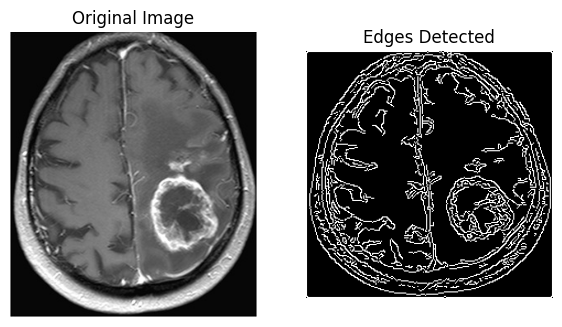

In [15]:
# show the image with the edges detected and the original image

fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image')

edges_image = processed_image.reshape(224, 224)
ax[1].imshow(edges_image, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Edges Detected')

plt.show()

In [8]:
from sklearn.svm import SVC

# Create the SVM model
svm_model = SVC(kernel='linear', C=1)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = svm_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9605978260869565


In [16]:
def apply_histogram_equalization(image):
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

def preprocess_image(image):
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    equalized_image = apply_histogram_equalization(grayscale_image)
    equalized_image = equalized_image.flatten()
    return equalized_image

def load_and_preprocess_data():
    data = []
    labels = []

    for file in image_files_tumor:
        img = cv2.imread(url_tumor + file)
        equalized_image = preprocess_image(img)
        data.append(equalized_image)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        img = cv2.imread(url_healthy + file)
        equalized_image = preprocess_image(img)
        data.append(equalized_image)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [17]:
data, labels = load_and_preprocess_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [20]:
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (2385).jpg'
sample_image = cv2.imread(sample_image_path)
processed_image = preprocess_image(sample_image)
processed_image = processed_image.reshape(1, -1)  # Reshape for prediction

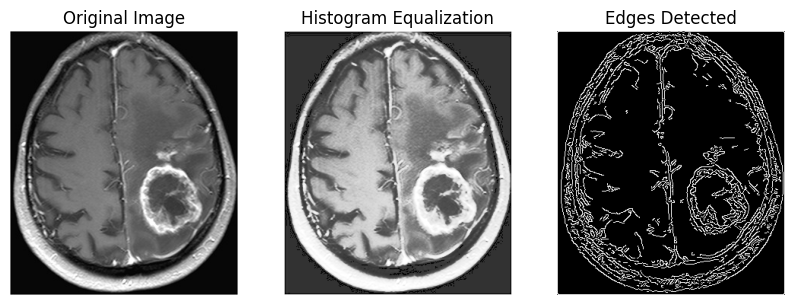

In [25]:
# plot the image with the histogram equalization, edges detected and the original image

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image')

equalized_image = apply_histogram_equalization(cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY))
ax[1].imshow(equalized_image, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Histogram Equalization')

edges_image = apply_canny_edge_detection(cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY))
ax[2].imshow(edges_image, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Edges Detected')

plt.show()


#### Random Forest Model

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9633


### Xgboost Model

In [ ]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

### Using VGG for features extraction

In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
def extract_vgg_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.flatten()

In [1]:
def load_and_preprocess_data(image_files_tumor, image_files_normal, url_tumor, url_healthy):
    data = []
    labels = []

    for file in image_files_tumor:
        features = extract_vgg_features(url_tumor + file)
        data.append(features)
        labels.append(1)  # 1 for tumor

    for file in image_files_normal:
        features = extract_vgg_features(url_healthy + file)
        data.append(features)
        labels.append(0)  # 0 for normal

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

```python 

data, labels = load_and_preprocess_data(image_files_tumor, image_files_normal, url_tumor, url_healthy)

# save the data and labels
np.save('data.npy', data)
np.save('labels.npy', labels)
```

In [17]:
# load the data and labels
data = np.load('data.npy')
labels = np.load('labels.npy')

# Split the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9565


In [27]:
sample_image_path = 'Brain Tumor Data Set/Brain Tumor/Cancer (492).jpg'

### xgboost model


In [66]:
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

c:\Users\noa12\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.9769


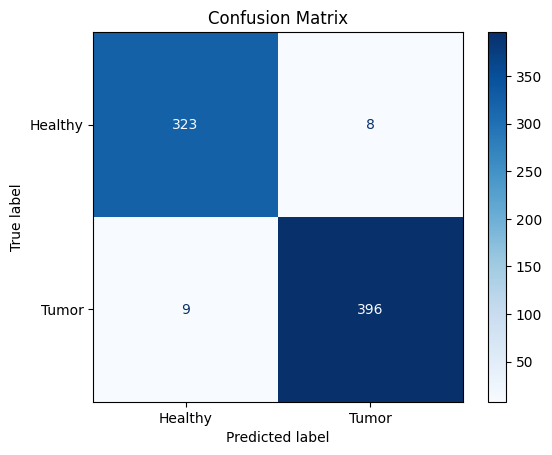

In [71]:
plot_confusion_matrix(y_val, y_pred, ['Healthy', 'Tumor'])

In [10]:
# SVM model
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.9810


#### Voting Classifier

In [19]:
# Create the models
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svc = SVC(kernel='linear', C=1)
lr = LogisticRegression(C=1, max_iter=1000)
xgbooost = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('svc', svc), ('lr', lr), ('xgboost', xgbooost)], voting='hard', verbose=True, n_jobs=-1)

# Train the model
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f'Voting Classifier Validation Accuracy: {accuracy:.4f}')

# save the model
joblib.dump(voting_clf, 'voting_clf.pkl')

Voting Classifier Validation Accuracy: 0.9810


['voting_clf.pkl']